<a href="https://colab.research.google.com/github/ashish1610dhiman/pinn_option_pricing/blob/main/european_call/a_cv_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import os
from european_utils import EuropeanOptionData
%matplotlib inline

In [103]:
N_EPOCH = 10000
LEARNING_RATE = 4e-3
HIDDEN_LAYER = 70
HIDDEN_WIDTH = 8
N_sample = 500
EXPERIMENT_NAME = "exp8"
PHYSICS_PENALTY = 10**3

experiment_dir = f"./{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [104]:
import logging
from datetime import datetime
logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [105]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

INFO:root:Running on device=cpu


### Parameters for the experiment

In [106]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")

INFO:root:N_EPOCH: 10000
INFO:root:LEARNING_RATE: 0.004
INFO:root:HIDDEN_LAYER: 70
INFO:root:HIDDEN_WIDTH: 8
INFO:root:N_sample: 500
INFO:root:EXPERIMENT_NAME: exp8


## Declare parameters for European Call

In [107]:
K = 40
r = 0.05
sigma = 0.5
T = 1
S_range = [0, 160]
t_range = [0, T]

In [108]:
euro_call_data = EuropeanOptionData(t_range,S_range,K,r,sigma)

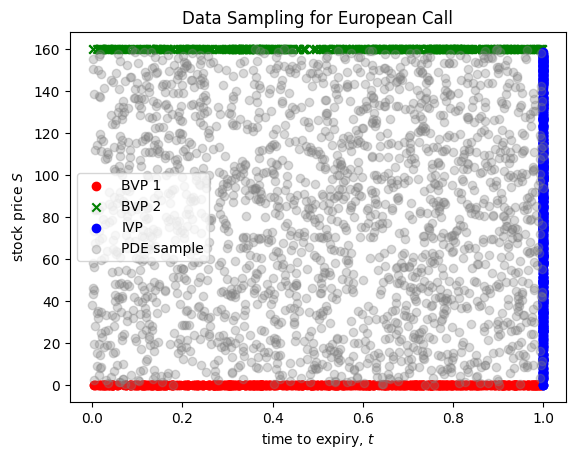

In [109]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = euro_call_data.get_bvp_data(500)
ivp_x1,ivp_y1 = euro_call_data.get_ivp_data(500)
diff_x1,diff_y1 = euro_call_data.get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel("time to expiry, $t$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for European Call")
plt.legend()

### Train Pytorch Model

In [110]:
class EuropeanCall(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(EuropeanCall, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        # activation2 = nn.Tanh()

        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation1
        )

        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.BatchNorm1d(N_HIDDEN),
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation1
            ) for _ in range(N_LAYERS)
        ])

        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # Apply the first layer
        out = self.fcs(x)
        # Apply hidden layers with residual connections
        for layer in self.fch[:self.N_HIDDEN//4]:
            out = out + layer(out)
        # Apply the final layer
        out = self.fce(out)
        return out

model = EuropeanCall(2,1,HIDDEN_LAYER,HIDDEN_WIDTH)
logging.info(f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

INFO:root:Model parameters : 41.16K


In [111]:
# N_sample = 500
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

In [ ]:
for i in range(N_EPOCH):
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_ivp_data_tensor(N_sample)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_bvp_data_tensor(N_sample)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_diff_data_tensor(N_sample,mul=4)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.4f}")


Epoch 500, Loss: 7341.3140
Epoch 1000, Loss: 7326.5537
Epoch 1500, Loss: 7322.7979
Epoch 2000, Loss: 7325.2017
Epoch 2500, Loss: 7330.8579
Epoch 3000, Loss: 7328.4438
Epoch 3500, Loss: 7342.1221


### Training Curve

In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")
plt.savefig(experiment_dir+"/total_loss.jpg")

In [ ]:
tail_result = loss_df.rolling(50).mean().tail(1).to_markdown()
logging.info(f"Loss results")
logging.info(f"{tail_result}")


In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8)
plt.title("Training Curve for Moving Average of losses")
plt.savefig(experiment_dir+"/ivp_bs_loss.jpg")

## Visualisation of Results

In [ ]:
# euro_call_data.get_analytical_soln(torch.tensor([80]),torch.tensor([1]))

In [ ]:
s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)

s_flat = s_grid.flatten()
t_flat = t_grid.flatten()
# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)
y_analytical_test = euro_call_data.get_analytical_soln(X_test[:,1],X_test[:,0])
print(X_test.shape,y_analytical_test.shape)

In [ ]:
model.eval();
with torch.no_grad():
  y_pinn_test = model(X_test)

In [ ]:
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)
plt.savefig(experiment_dir+"/true_vs_pred.jpg")

In [ ]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
err = y_pinn_test.detach().numpy().reshape(s_grid.shape) - y_analytical_test.detach().numpy().reshape(s_grid.shape)
ax.plot_surface(s_grid, t_grid, err, cmap = "viridis")
ax.set_title("Analytical Soln - Predicted")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

### Corealtion

In [ ]:
plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")
plt.savefig(experiment_dir+"/true_vs_pred_coef.jpg")
coef_res = np.corrcoef(y_pinn_test.detach().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.detach().numpy())
logging.info(f"Coef: {coef_res[0,1]:.3f}")

In [ ]:
!zip -r ./{experiment_dir}.zip $experiment_dir